## Overview

an example simulated annealing problem set up and solution

In [1]:
import json
import copy

import numpy as np  
import numpy.random as random  


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## I. Simulated Annealing -- Main Loop

The main loop of simulated annealing repeatedly generates successors in the neighborhood of the current state and considers moving there according to an acceptance probability distribution parameterized by a cooling schedule.  See the [simulated-annealing function](https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md) pseudocode from the AIMA textbook online at github. 

In [2]:
def simulated_annealing(problem, schedule):
    """
    
    Parameters
    ----------
    problem : Problem
        An optimization problem, already initialized to a random starting state.
        The Problem class interface must implement a callable method
        "successors()" which returns states in the neighborhood of the current
        state, and a callable function "get_value()" which returns a fitness
        score for the state. (See the `TravelingSalesmanProblem` class below
        for details.)

    schedule : callable
        A function mapping time to "temperature". "Time" is equivalent in this
        case to the number of loop iterations.
    
    Returns
    -------
    Problem
        An approximate solution state of the optimization problem
        
    AIMA simulated_annealing() pseudocode
        https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md
    """     
    
    switch = True
    t = 0
    current = problem.copy()
    while switch == True:
        
        T = schedule(t)
        if T< 1e-10:
            return current
        mutant = np.random.choice(current.successors())
        delta = mutant.get_value() - current.get_value() 
        if delta > 0:
            current = mutant.copy()
            continue
        else:
            p = np.exp(delta/T)
            if np.random.choice(2, p = [1-p, p]):
                current = mutant.copy()
                
        t+=1
            
        
    

## II. Representing the Problem

In order to use simulated annealing we need to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of simulated annealing and other optimization techniques.  Since the TSP deals with a close loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid.  The _state_ will then consist of an ordered sequence (a list) of the cities; the path is defined as the sequence generated by traveling from each city in the list to the next in order.

In [3]:
class TravelingSalesmanProblem:
    """Representation of a traveling salesman optimization problem.  The goal
    is to find the shortest path that visits every city in a closed loop path.
    
    
    Parameters
    ----------
    cities : list
        A list of cities specified by a tuple containing the name and the x, y
        location of the city on a grid. e.g., ("Atlanta", (585.6, 376.8))
    
    Attributes
    ----------
    names
    coords
    path : list
        The current path between cities as specified by the order of the city
        tuples in the list.
    """
    def __init__(self, cities):
        self.path = copy.deepcopy(cities)
    
    def copy(self):
        """Return a copy of the current board state."""
        new_tsp = TravelingSalesmanProblem(self.path)
        return new_tsp
    
    @property
    def names(self):
        """Strip and return only the city name from each element of the
        path list. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> ["Atlanta", ...]
        """
        names, _ = zip(*self.path)
        return names
    
    @property
    def coords(self):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*self.path)
        return coords
    
    def successors(self):
        """Return a list of states in the neighborhood of the current state by
        switching the order in which any adjacent pair of cities is visited.
        
        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [A, B, D, C], [A, C, B, D], [B, A, C, D],
        and [D, B, C, A]. (The order of successors does not matter.)
        
        In general, a path of N cities will have N neighbors (note that path wraps
        around the end of the list between the first and last cities).

        Returns
        -------
        list<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """
        #test_path = ["A", "B", "C", "D", "E"]
        neighbors = []
        for i in range(len(self.path)):

            new_path = [self.path[(i+1)%len(self.path)]] +[self.path[i]]

            for n in range(2,len(self.path)):
                new_path += [self.path[(i+n)%len(self.path)]]
            neighbors.extend([TravelingSalesmanProblem(new_path)])             

        return neighbors
        
        

    def get_value(self):
        """Calculate the total length of the closed-circuit path of the current
        state by summing the distance between every pair of adjacent cities.  Since
        the default simulated annealing algorithm seeks to maximize the objective
        function, return -1x the path length. (Multiplying by -1 makes the smallest
        path the smallest negative number, which is the maximum value.)
        
        Returns
        -------
        float
            A floating point value with the total cost of the path given by visiting
            the cities in the order according to the self.cities list
        
        """
        
        p = self.path
        return -sum([np.linalg.norm(np.array(x1[1])\
                                            - np.array(x2[1]))for x1, x2 in zip(*[iter(p), iter(p[1:]+[p[0]])])])
       

## III. Define the Temperature Schedule

The most common temperature schedule is simple exponential decay:
$T(t) = \alpha^t T_0$


In most cases, the valid range for temperature $T_0$ can be very high (e.g., 1e8 or higher), and the _decay parameter_ $\alpha$ should be close to, but less than 1.0 (e.g., 0.95 or 0.99).  We need to experiment to see how these parameters effect the simulated annealing function. 

We can also experiment with other schedule functions -- linear, quadratic, etc.  

In [4]:
#Using global vars for now, we can imbed into the function later.
alpha = 0.95
temperature=1e30

def schedule(time):
    return temperature * alpha ** time
    #raise NotImplementedError

## IV. Run Simulated Annealing on a Larger TSP
We can now try and solve with up to 30 cities we loaded

In [5]:
#define a grapher function

"""Read input data and define helper functions for visualization."""

# Map services and data available from U.S. Geological Survey, National Geospatial Program.
#  http://www.usgs.gov/visual-id/credit_usgs.html for further information
map = mpimg.imread("map.png")  # US States & Capitals map

# List of 30 US state capitals and corresponding coordinates on the map
with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
capitals_list = list(capitals.items())

def show_path(path, starting_city, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    x, y = list(zip(*path))
    _, (x0, y0) = starting_city
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

Initial path value: 7084.91
[('Boston', [738.4, 190.8]), ('Hartford', [719.6, 205.2]), ('Austin', [389.2, 448.4]), ('Montgomery', [559.6, 404.8]), ('Denver', [293.6, 274.0]), ('Madison', [500.8, 217.6]), ('Columbia', [632.4, 364.8]), ('Boise', [159.6, 182.8]), ('Albany', [702.0, 193.6]), ('Raleigh', [662.0, 328.8]), ('Oklahoma City', [392.8, 356.4]), ('Columbus', [590.8, 263.2]), ('Tallahassee', [594.8, 434.8]), ('Harrisburg', [670.8, 244.0]), ('Little Rock', [469.2, 367.2]), ('Atlanta', [585.6, 376.8]), ('Providence', [735.2, 201.2]), ('Lansing', [563.6, 216.4]), ('Saint Paul', [451.6, 186.0]), ('Nashville', [546.4, 336.8]), ('Indianapolis', [548.0, 272.8]), ('Salt Lake City', [204.0, 243.2]), ('Sacramento', [68.4, 254.0]), ('Salem', [80.0, 139.2]), ('Baton Rouge', [489.6, 442.0]), ('Richmond', [673.2, 293.6]), ('Trenton', [698.8, 239.6]), ('Des Moines', [447.6, 246.0]), ('Phoenix', [179.6, 371.2]), ('Jackson', [501.6, 409.6])]


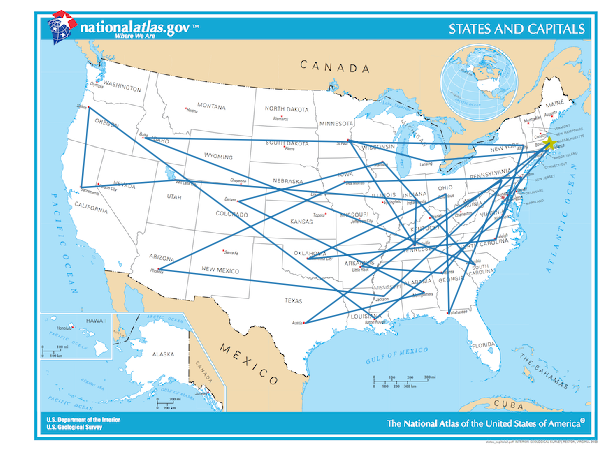

In [6]:
# Create the problem instance and plot the initial state
num_cities = 30
capitals_tsp = TravelingSalesmanProblem(capitals_list[:num_cities])
starting_city = capitals_list[0]
print("Initial path value: {:.2f}".format(-capitals_tsp.get_value()))
print(capitals_list[:num_cities])  # The start/end point is indicated with a yellow star
show_path(capitals_tsp.coords, starting_city)

Final path length: 5641.32
[('Boston', [738.4, 190.8]), ('Hartford', [719.6, 205.2]), ('Trenton', [698.8, 239.6]), ('Harrisburg', [670.8, 244.0]), ('Raleigh', [662.0, 328.8]), ('Columbia', [632.4, 364.8]), ('Atlanta', [585.6, 376.8]), ('Madison', [500.8, 217.6]), ('Providence', [735.2, 201.2]), ('Albany', [702.0, 193.6]), ('Boise', [159.6, 182.8]), ('Little Rock', [469.2, 367.2]), ('Columbus', [590.8, 263.2]), ('Lansing', [563.6, 216.4]), ('Oklahoma City', [392.8, 356.4]), ('Sacramento', [68.4, 254.0]), ('Saint Paul', [451.6, 186.0]), ('Indianapolis', [548.0, 272.8]), ('Nashville', [546.4, 336.8]), ('Salt Lake City', [204.0, 243.2]), ('Salem', [80.0, 139.2]), ('Phoenix', [179.6, 371.2]), ('Des Moines', [447.6, 246.0]), ('Richmond', [673.2, 293.6]), ('Austin', [389.2, 448.4]), ('Jackson', [501.6, 409.6]), ('Montgomery', [559.6, 404.8]), ('Tallahassee', [594.8, 434.8]), ('Baton Rouge', [489.6, 442.0]), ('Denver', [293.6, 274.0])]


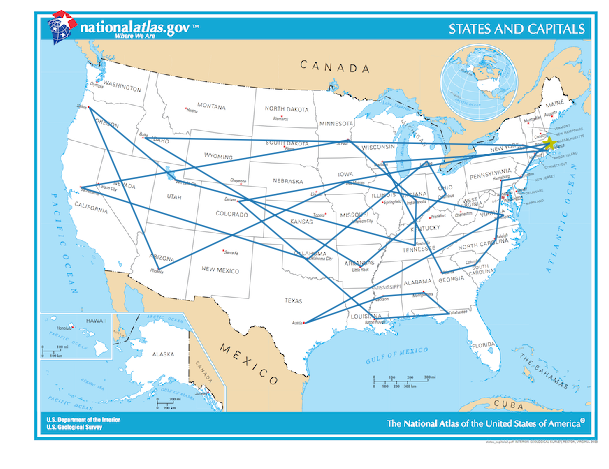

In [9]:
# set the decay rate and initial temperature parameters, then run simulated annealing to solve the TSP
alpha = 0.95
temperature=1e6
result = simulated_annealing(capitals_tsp, schedule)
print("Final path length: {:.2f}".format(-result.get_value()))
print(result.path)
show_path(result.coords, starting_city)